# Libraries

In [1]:
%pip install llama-index
%pip install transformers
%pip install torch
%pip install sentence-transformers
%pip install "llama-index-embeddings-huggingface"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


# Semantic Chunks Generation

### Loading Data

In [2]:
import pandas as pd
from typing import List, Dict
from llama_index.core import VectorStoreIndex, ServiceContext, Document
from llama_index.core.node_parser import SentenceSplitter, SemanticSplitterNodeParser
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
def load_data(csv_path: str, text_col: List[str], metadata_cols: List[str]) -> List[Document]:
    """
    Load documents and include class in metadata
    """
    df = pd.read_csv(csv_path)
    documents = []
    for _, row in df.iterrows():
        text = str(row[text_col])
        doc = Document(
            text=text,
            metadata= {col: row[col] for col in metadata_cols}
        )
        documents.append(doc)
    return documents

# DATA_PATH = '/content/drive/MyDrive/Omdena/Regulatory RAG (SL Chapter)/code/model dev/data/'
DATA_PATH = 'data/final_dataset/'
FILE_NAME = 'v0_LK_tea_dataset.csv'

text_col = 'markdown_content'
metadata_cols = ['id']

documents = load_data(DATA_PATH+FILE_NAME, text_col, metadata_cols)
len(documents)

167

### Embedding Model

In [4]:
def setup_embedding_model():
    """
    Setup HuggingFace embedding model
    """
    model_name = 'BAAI/bge-small-en-v1.5'
    return HuggingFaceEmbedding(
        model_name=model_name,
        trust_remote_code=True,
        cache_folder="/content/drive/MyDrive/Omdena/Regulatory RAG (SL Chapter)/code/model dev/cached_models/"
        )

embed_model = setup_embedding_model()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Semantic Chunking

In [5]:
def create_semantic_chunks(
    documents: List[Document],
    embed_model,
    chunk_size: int = 768,
    chunk_overlap: int = 256) -> List[Document]:
    """
    Create semantic chunks using LlamaIndex's SemanticSplitterNodeParser
    """
    # Create sentence splitter as the base text splitter
    text_splitter = SentenceSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )

    # Setup semantic splitter
    semantic_splitter = SemanticSplitterNodeParser(
        text_splitter=text_splitter,
        embed_model=embed_model,
        buffer_size=1,  # Adjust based on your needs
        breakpoint_percentile_threshold=80  # Adjust semantic boundary detection
    )

    print(f"Generating chunks for {len(documents)} documents...")

    # Process documents with TQDM
    start_time = time.monotonic()

    # Wrap documents with TQDM for progress tracking
    nodes = []
    for doc in tqdm(documents, desc="Generating Semantic Chunks", unit="document"):
        # Process each document individually to ensure progress tracking
        doc_nodes = semantic_splitter.get_nodes_from_documents([doc])
        nodes.extend(doc_nodes)

    end_time = time.monotonic()

    # Performance and chunk information
    elapsed_time = end_time - start_time
    chunk_count = len(nodes)

    # Chunk count and completion time
    print('\n' + '='*15, 'Chunking Information', '='*15)
    print(f"Total Chunks Generated: {chunk_count}")
    print(f"Total Time Taken: {elapsed_time:.4f} seconds")
    print(f"Generation Rate: {(chunk_count/elapsed_time):.4f} chunks/second")
    print('='*50 + '\n')

    # Convert nodes back to documents while preserving metadata
    semantic_docs = [
        Document(
            text=node.text,
            metadata=node.metadata or {}
        ) for node in nodes
    ]

    return semantic_docs

semantic_chunks = create_semantic_chunks(documents, embed_model)

Generating chunks for 167 documents...


Generating Semantic Chunks:   0%|          | 0/167 [00:00<?, ?document/s]


=============== Chunking Information ===============
Total Chunks Generated: 1658
Total Time Taken: 1263.8627 seconds
Generation Rate: 1.3119 chunks/second



### EDA

In [6]:
semantic_chunks_df = pd.DataFrame([{'id': chunk.metadata['id'], 'semantic_chunk_text': chunk.text} for chunk in semantic_chunks])
semantic_chunks_df.head()

,id,semantic_chunk_text
0,0,"# Tea Subsidy\r\n\r\nActs Nos. 12 of 1958, 66 ..."
1,0,33 of 1966.\r\n\r\n# AN ACT TO PROVIDE FOR THE...
2,0,1. This Act may be cited as the Tea Subsidy Ac...
3,0,"11,527 of 19th September, 1958.\r\n\r\n# Tea S..."
4,0,"[Â§ 3, 66 of 1961.]\r\n\r\n"


In [ ]:
# save_path = '/content/drive/MyDrive/Omdena/Regulatory RAG (SL Chapter)/code/model dev/data/'
save_path = 'data/'
save_fname = 'semantic_chunks.csv'

semantic_chunks_df.to_csv(save_path+save_fname, index=False)

In [8]:
# proxy token stats
chunk_len = pd.Series([len(chunk.split()) for chunk in semantic_chunks_df.semantic_chunk_text])
chunk_len.describe()

,0
count,1658.000000
mean,109.485525
std,152.755895
min,1.000000
25%,22.000000
50%,62.000000
75%,132.000000
max,1602.000000


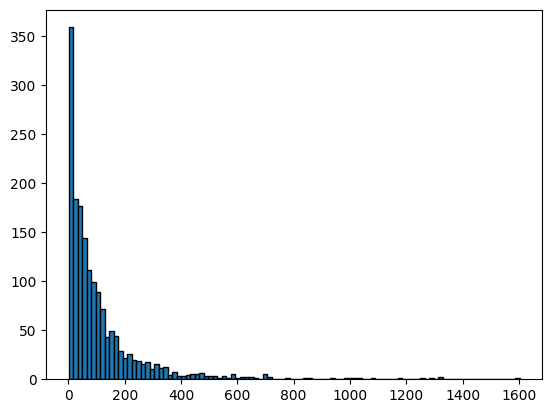

In [9]:
plt.hist(chunk_len, bins=100, edgecolor='black')
plt.show()